# https://www.tensecgames.com/
tensecgames 3번째 프로젝트

<b>추후 작업</b>
1. 라벨 세분화

# 데이터 세트
https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=528

### 📚import Libraries

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import requests
import io
from PIL import Image
import cv2

from tensorflow.keras import models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [33]:
# gpu확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

### 🗂️데이터 셋 정보

train : 10,025 이미지<br>
validation : 1,539 이미지<br>
test : 1,504 이미지<br>

In [8]:
train_meta_data_path = "./asset/dataset/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./asset/dataset/train_images"

val_meta_data_path = "./asset/dataset/custom_val_dataset.csv"
val_meta_data = pd.read_csv(val_meta_data_path)
val_image_directory = "./asset/dataset/val_images"

test_meta_data_path = "./asset/dataset/custom_test_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./asset/dataset/test_images"

In [9]:
train_meta_data['image_path']='./asset/dataset/train_images/'+train_meta_data['image_path']
val_meta_data['image_path']='./asset/dataset/val_images/'+val_meta_data['image_path']
test_meta_data['image_path']='./asset/dataset/test_images/'+test_meta_data['image_path']

In [10]:
# train_meta_data.head(1)

,family_id,person_id,age_class,image_path
0,F0001,D,a,./asset/dataset/train_images/F0001_AGE_D_18_a1...


### 💽detection

In [25]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')  # 얼굴 검출기 모델

In [11]:
def get_face(img_path):
    img_byte=cv2.imread(img_path)#.convert('RGB'))
    faces = face_cascade.detectMultiScale(img_byte, 1.3, 5)
#     img_byte = cv2.cvtColor(img_byte, cv2.COLOR_BGR2RGB)
    # 검출기 예외처리
    if faces == ():
        _, img_with_box = cv2.imencode('.jpg', img_byte)
        img_with_box = base64.b64encode(img_with_box).decode('utf-8')
        return {"classification_age": "얼굴이 검출되지 않았습니다.", "face_byte": img_with_box}

    x_from, _, _, _ = np.min(faces, axis=0)
    _, y_from, x_length, y_length = np.max(faces, axis=0)
    face = img_byte[y_from: y_from + y_length, x_from: x_from + x_length]
    face = cv2.resize(face, (128, 128), interpolation=cv2.INTER_CUBIC)
    return face

In [12]:
for _,img_path in enumerate(train_meta_data['image_path']):
    try:
        img=get_face(img_path)
        cv2.imwrite(img_path, img)
        train_meta_data.loc[_,'detection']=0
    except:
        train_meta_data.loc[_,'detection']=1

In [13]:
for _,img_path in enumerate(val_meta_data['image_path']):
    try:
        img=get_face(img_path)
        cv2.imwrite(img_path, img)
        val_meta_data.loc[_,'detection']=0
    except:
        val_meta_data.loc[_,'detection']=1

In [14]:
for _,img_path in enumerate(test_meta_data['image_path']):
    try:
        img=get_face(img_path)
        cv2.imwrite(img_path, img)
        test_meta_data.loc[_,'detection']=0
    except:
        test_meta_data.loc[_,'detection']=1

### 💽데이터 제네레이터 생성
훈련 데이터셋의 경우 밝기 줌 등 다양한 데이터 증강 설정

In [5]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size =128
 
# Training 수
epochs = 20
 
# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
min_LearningRate = 5e-5 # 0.00005
Decay = 1e-6
 
img_width = 128
img_height = 128

In [34]:
DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255, # 스케일 정규화(노말라이제이션)
    rotation_range=20, # 정수. 무작위 회전의 각도 범위입니다.
    width_shift_range=0.2, # 전체 가로넓이에서의 비율
    height_shift_range=0.2, # 전체 세로넓이에서의 비율
#     shear_range=0.2, # 반시계 방향 층밀리기 각도
    zoom_range=0.2, # 무작위 줌의 범위
    brightness_range=[0.7, 1.3], # 밝기 조절 범위
#     horizontal_flip=True, # 무작위로 가로로 뒤집기
#     vertical_flip=True, # 무작위로 세로로 뒤집기
#     data_format="channels_last", #이미지 데이터 형식
#     channel_shift_range =100, #무작위로 색상이동범위
#     validation_split=0.10 # 검증의 용도로 남겨둘 남겨둘 이미지의 비율
)

# Generator의 instance 생성 (Train)
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
                                        dataframe = train_meta_data, x_col='image_path', y_col='age_class',
                                        target_size=(img_width, img_height), 
                                        class_mode='categorical',
                                        batch_size=batch_size,)
#                                         shuffle=True)

DATAGEN_VALID = ImageDataGenerator(rescale=1.0 / 255)

VALID_GENERATOR = DATAGEN_VALID.flow_from_dataframe(
                                        dataframe = val_meta_data, x_col='image_path', y_col='age_class',
                                        target_size=(img_width, img_height), 
                                        class_mode='categorical',
                                        batch_size=batch_size,
                                        shuffle=True)

### 💻모델 정의
ResNet50V2모델 선정<br>
초반 모델의 경우 weights를 그대로 가져다 활용

In [12]:
# 모델 Return
ResNetModel = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width,img_height,3), pooling=None)
x = GlobalAveragePooling2D()(ResNetModel.output)
predictions = Dense(len(set(train_meta_data['age_class'])), activation='softmax')(x)
 
DeepLearning = Model(inputs=ResNetModel.input, outputs=predictions)
 
# learning parameter를 더하여 최종 model compile
DeepLearning.compile(optimizer=
         SGD(learning_rate=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
)

In [35]:
DeepLearning.summary()

In [14]:
# ModelCheckpointm, val_accuracy, val_loss
CP = ModelCheckpoint(filepath='model/' + 'FaceClassification_CP'+str(batch_size)+'_'+str(datetime.now()).split(' ')[0]+'.hdf5',
     monitor='val_loss', verbose=1, save_besta_only=False, mode='min')

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3, verbose=10, min_lr=min_LearningRate)
CALLBACK = [CP, LR]

### 📜모델 훈련

In [29]:
#모델 훈련
DeepLearning.fit(
    TRAIN_GENERATOR,
    epochs=epochs,
    callbacks=CALLBACK,
#     shuffle=True,
    validation_data=VALID_GENERATOR)

In [36]:
# loss 값 비교
f,ax=plt.subplots(2,1)

ax[0].plot(DeepLearning.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(DeepLearning.history.history['val_loss'],color='r',label='Validation Loss')

ax[1].plot(DeepLearning.history.history['acc'],color='b',label='Training  Accuracy')
ax[1].plot(DeepLearning.history.history['val_acc'],color='r',label='Validation Accuracy')

### 👓모델 검증

In [17]:
DeepLearning=models.load_model('./model/FaceClassification_CP128_2023-10-25.hdf5')

In [38]:
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255)

TEST_GENERATOR = DATAGEN_TEST.flow_from_dataframe(
                                        dataframe=test_meta_data, x_col='image_path', y_col='age_class',
                                        target_size=(img_width, img_height), class_mode='categorical',
                                        batch_size=batch_size, shuffle=False)

In [19]:
TEST_Prediction = DeepLearning.predict_generator(TEST_GENERATOR, verbose=10)
test_meta_data['pred_label']=np.asarray(['a','b','c','d','e','f','g','h'])[np.argmax(TEST_Prediction, axis = 1)]

In [37]:
print("f1_score :",f1_score(test_meta_data['age_class'], test_meta_data['pred_label'],average='macro'))
print("accuracy_score :",accuracy_score(test_meta_data['age_class'], test_meta_data['pred_label']))

### 💯모델 추론
실제 서비스에 적용할때는 cv2 케스케이드 분류기를 검출기로 활용할 예정

In [31]:
from tensorflow.keras.models import load_model

DeepLearning=load_model("./model/FaceClassification_CP128_2023-10-25.hdf5")

In [22]:
label_li=[
    '0-6 years old',
    '7-12 years old',
    '13-19 years old',
    '20-30 years old',
    '31-45 years old',
    '46-55 years old',
    '56-66 years old',
    '67-80 years old'
]

In [23]:
# 이미지 불러오고 convert
img_path = 'https://image.kmib.co.kr/online_image/2020/1220/611811110015341674_1.jpg'
# img_path='http://ewcdata.com/images/cont/member12.png'
response = requests.get(img_path)
img_byte=np.array(Image.open(io.BytesIO(response.content)))

나이대 :  31-45 years old


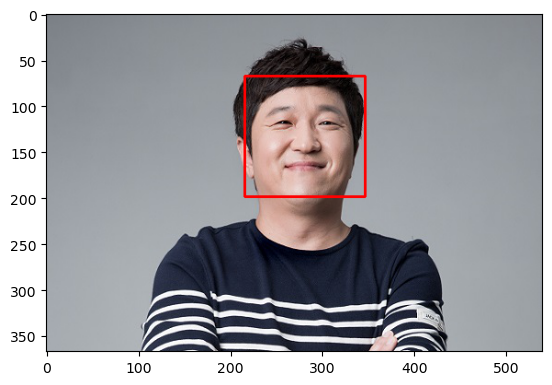

In [32]:
img_with_box = img_byte.copy()
#얼굴 검출
faces = face_cascade.detectMultiScale(img_byte, 1.3, 5)
x_from, _, _, _ = np.min(faces, axis=0)
_, y_from, x_length, y_length = np.max(faces, axis=0)

#얼굴 이미지 추출
face=img_byte[y_from: y_from + y_length, x_from: x_from + x_length]
face=cv2.resize(face, (128,128), interpolation=cv2.INTER_CUBIC)
face=(face / 255.0)
face=np.expand_dims(face, axis=0)
print('나이대 : ',label_li[DeepLearning.predict(face).argmax()])

# 얼굴 박스
tmp=cv2.rectangle(img_with_box, (x_from, y_from), (x_from + x_length, y_from + y_length), (255, 0, 0), 2)  # 사각형 그리기 (빨간색)
plt.figure()
plt.imshow(tmp)
plt.show()